In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

In [2]:
# load data
data_dir = 'temp'
mnist = read_data_sets(data_dir)

Extracting temp/train-images-idx3-ubyte.gz
Extracting temp/train-labels-idx1-ubyte.gz
Extracting temp/t10k-images-idx3-ubyte.gz
Extracting temp/t10k-labels-idx1-ubyte.gz


In [3]:
print(mnist.train.images.shape)
print(mnist.train.images[0].shape)

(55000, 784)
(784,)


In [4]:
# train data & test data(28*28 =784)

# np.reshape: Gives a new shape to an array without changing its data.
# Parameters:
# a : array_like  Array to be reshaped.
# newshape : int or tuple of ints
# order : {‘C’, ‘F’, ‘A’}, optional
# Returns:reshaped_array : ndarray

train_xdata = np.array([np.reshape(x, (28,28)) for x in mnist.train.images])
test_xdata = np.array([np.reshape(x, (28,28)) for x in mnist.test.images])
train_labels = mnist.train.labels
test_labels = mnist.test.labels

print( train_xdata[0].shape)

(28, 28)


### tf.nn.conv2d(卷积层) ###
**Computes a 2-D convolution given 4-D input and filters tensors.**  
**tf.nn.conv2d(input, filters, strides, padding, data_format='NHWC', dilations=None, name=None)**  
**input**: A 4-D tensor. [batch, in_height, in_width, in_channels]  
**filters**: A 4-D tensor of shape [filter_height, filter_width, in_channels, out_channels]  
**strides**: Must have strides[0] = strides[3] = 1.   
For the most common case of the same horizontal and vertices strides, strides = [1, stride, stride, 1].  
**padding**: "SAME" or "VALID"   
**data_format**: An optional string from: "NHWC", "NCHW". Defaults to "NHWC".   

VALID，输出的形状为：$ new\_height = new\_width =\lceil  \frac{(W+2P–F)}{S} \rceil+1  $   
SAME，输出的形状为：$ new\_height=new\_width=\lceil \frac{ W } { S}\rceil $   

W为输入的size，P为Padding的宽度,F为filter的size，S为步长，⌈⌉为向上取整符号。

### tf.nn.max_pool(池化层) ###
**Performs the max pooling on the input.**  
**tf.nn.max_pool(input, ksize, strides, padding, data_format=None, name=None)**  
**input**: Tensor of rank N+2, of shape [batch_size] + input_spatial_shape + [num_channels] if data_format does not start with "NC" (default), or [batch_size, num_channels] + input_spatial_shape if data_format starts with "NC". Pooling happens over the spatial dimensions only.  
**ksize**: An int or list of ints that has length 1, N or N+2. The size of the window for each dimension of the input tensor.  
**strides**: An int or list of ints that has length 1, N or N+2. The stride of the sliding window for each dimension of the input tensor.  
**padding**: A string, either 'VALID' or 'SAME'. The padding algorithm. See the "returns" section of tf.nn.convolution for details.  
**data_format**: A string. Specifies the channel dimension. For N=1 it can be either "NWC" (default) or "NCW", for N=2 it can be either "NHWC" (default) or "NCHW" and for N=3 either "NDHWC" (default) or "NCDHW".

In [5]:
#由于图像是灰度图，所以该图像的深度为1，颜色通道数为1

batch_size = 100 #训练集一次批量的大小
learning_rate = 0.005
evaluation_size = 500 # 测试集大小
image_width = train_xdata[0].shape[0]
image_height = train_xdata[0].shape[1]
#
target_size = max(train_labels)+1
num_channels = 1
#迭代次数
generations = 500

conv1_features = 25
conv2_features = 50
max_pool_size1 = 2
max_pool_size2 = 2
fully_connected_size1 = 100

In [6]:
#training input
x_input_shape = (batch_size, image_height, image_width, num_channels)
x_input = tf.placeholder(tf.float32, shape=x_input_shape)
y_target = tf.placeholder(tf.int32, shape=(batch_size))

#testing input
eval_input_shape = (evaluation_size, image_height, image_width, num_channels)
eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
eval_target = tf.placeholder(tf.int32, shape=(evaluation_size))

In [7]:
# tf.random.truncated_normal : Outputs random values from a truncated normal distribution.
# tf.random.truncated_normal(shape, mean=0.0, stddev=1.0, dtype=tf.dtypes.float32, seed=None, name=None)

#初始化 卷积核w 和 偏置项b 
conv1_w = tf.Variable(tf.truncated_normal(shape=[4,4,num_channels, conv1_features], stddev=0.1, dtype=tf.float32))
conv1_b = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

conv2_w = tf.Variable(tf.truncated_normal(shape=[4,4,conv1_features, conv2_features], stddev=0.1, dtype=tf.float32))
conv2_b = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

In [8]:
resulting_width = image_width//(max_pool_size1*max_pool_size2)
resulting_height = image_height//(max_pool_size1*max_pool_size2)

full_input_size = resulting_width * resulting_height * conv2_features
full1_w = tf.Variable(tf.truncated_normal(shape=[full_input_size,fully_connected_size1], stddev=0.1, dtype= tf.float32))
full1_b = tf.Variable(tf.truncated_normal(shape=[fully_connected_size1], stddev=0.1, dtype=tf.float32))

full2_w = tf.Variable(tf.truncated_normal(shape=[fully_connected_size1,target_size], stddev=0.1, dtype= tf.float32))
full2_b = tf.Variable(tf.truncated_normal(shape=[target_size], stddev=0.1, dtype=tf.float32))

In [9]:
def my_conv_net(input_data):
    #First Conv-ReLU-MaxPool Layer
    conv1 = tf.nn.conv2d(input_data, conv1_w, strides=[1,1,1,1], padding='SAME')
    print("conv1 shape:"+str(conv1.get_shape()))
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_b))
    print("relu1 shape:"+str(relu1.get_shape()))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1, max_pool_size1, max_pool_size1, 1], strides=[1, max_pool_size1,max_pool_size1, 1], padding='SAME')
    print("max_pool1 shape:"+str(max_pool1.get_shape()))
    
    #Second Conv-ReLu-MaxPoolLayer 
    conv2 = tf.nn.conv2d(max_pool1, conv2_w, strides=[1,1,1,1], padding='SAME')
    print("conv2 shape:"+str(conv2.get_shape()))
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_b))
    print("relu2 shape:"+str(relu2.get_shape()))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1, max_pool_size2, max_pool_size2, 1], strides=[1, max_pool_size2,max_pool_size2, 1], padding='SAME')
    print("max_pool2 shape:"+str(max_pool2.get_shape()))
    
    # fully connected layer
    final_conv_shape = max_pool2.get_shape().as_list()
    final_shape = final_conv_shape[1]*final_conv_shape[2]*final_conv_shape[3]
    flat_ouput = tf.reshape(max_pool2, [final_conv_shape[0],final_shape])
    print("flat_ouput:"+str(flat_ouput.get_shape()))
    
    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_ouput, full1_w), full1_b))
    print("fully_connected1:"+str(fully_connected1.get_shape()))
    final_model_output = tf.nn.relu(tf.add(tf.matmul(fully_connected1, full2_w), full2_b))
    print("final_model_output:"+str(final_model_output.get_shape()))
    return (final_model_output)
    

In [10]:
model_output = my_conv_net(x_input)

conv1 shape:(100, 28, 28, 25)
relu1 shape:(100, 28, 28, 25)
max_pool1 shape:(100, 14, 14, 25)
conv2 shape:(100, 14, 14, 50)
relu2 shape:(100, 14, 14, 50)
max_pool2 shape:(100, 7, 7, 50)
flat_ouput:(100, 2450)
fully_connected1:(100, 100)
final_model_output:(100, 10)


In [11]:
test_model_output = my_conv_net(eval_input)

conv1 shape:(500, 28, 28, 25)
relu1 shape:(500, 28, 28, 25)
max_pool1 shape:(500, 14, 14, 25)
conv2 shape:(500, 14, 14, 50)
relu2 shape:(500, 14, 14, 50)
max_pool2 shape:(500, 7, 7, 50)
flat_ouput:(500, 2450)
fully_connected1:(500, 100)
final_model_output:(500, 10)


In [12]:
# tf.nn.sparse_softmax_cross_entropy_with_logits
# Computes sparse softmax cross entropy between logits and labels.

# tf.nn.sparse_softmax_cross_entropy_with_logits(
#     labels, logits, name=None
# )

loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_target, logits=model_output))

In [13]:
my_optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
train_step = my_optimizer.minimize(loss)

In [14]:
prediction = tf.nn.softmax(model_output)
test_prediction = tf.nn.softmax(test_model_output)

In [15]:
def get_accuracy(logits, targets):
    batch_predictons = np.argmax(logits, axis=1)
    num_correct = np.sum(np.equal(batch_predictons, targets))
    return (100. * num_correct/batch_predictons.shape[0])

In [16]:
train_loss = []
train_acc =[]
test_acc=[]

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(generations):
    rand_index = np.random.choice(len(train_xdata), size=batch_size)
    rand_x = train_xdata[rand_index]
    rand_x = np.expand_dims(rand_x, 3)
    rand_y = train_labels[rand_index]
    train_dict = {x_input: rand_x, y_target:rand_y}
    sess.run(train_step, feed_dict=train_dict)
    temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
    temp_train_acc = get_accuracy(temp_train_preds, rand_y)
    if(i+1)%5 == 0:
        eval_index = np.random.choice(len(test_xdata), size= evaluation_size)
        eval_x = test_xdata[eval_index]
        eval_x = np.expand_dims(eval_x,3)
        eval_y = test_labels[eval_index]
        test_dict = {eval_input:eval_x, eval_target:eval_y}
        test_preds = sess.run(test_prediction, feed_dict=test_dict)
        temp_test_acc =get_accuracy(test_preds, eval_y)
        
        train_loss.append(temp_train_loss)
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)
        
        acc_and_loss =[(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss: {:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss)) 

Generation # 5. Train Loss: 2.32. Train Acc (Test Acc): 14.00 (18.40)
Generation # 10. Train Loss: 2.23. Train Acc (Test Acc): 27.00 (25.80)
Generation # 15. Train Loss: 2.18. Train Acc (Test Acc): 22.00 (21.20)
Generation # 20. Train Loss: 2.06. Train Acc (Test Acc): 36.00 (28.00)
Generation # 25. Train Loss: 2.10. Train Acc (Test Acc): 30.00 (31.80)
Generation # 30. Train Loss: 1.98. Train Acc (Test Acc): 38.00 (36.20)
Generation # 35. Train Loss: 2.09. Train Acc (Test Acc): 31.00 (37.20)
Generation # 40. Train Loss: 1.82. Train Acc (Test Acc): 47.00 (46.60)
Generation # 45. Train Loss: 1.79. Train Acc (Test Acc): 39.00 (43.60)
Generation # 50. Train Loss: 1.56. Train Acc (Test Acc): 48.00 (42.20)
Generation # 55. Train Loss: 1.80. Train Acc (Test Acc): 35.00 (49.60)
Generation # 60. Train Loss: 1.65. Train Acc (Test Acc): 48.00 (44.20)
Generation # 65. Train Loss: 1.65. Train Acc (Test Acc): 38.00 (43.40)
Generation # 70. Train Loss: 1.63. Train Acc (Test Acc): 47.00 (45.80)
Generat

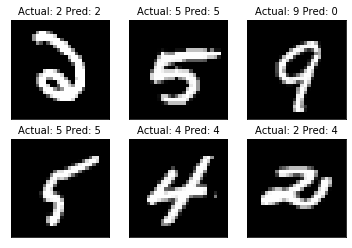

In [17]:
# Plot the 6 of the last batch results: 
actuals = rand_y[0:6] 
predictions = np.argmax(temp_train_preds,axis=1)[0:6] 
images = np.squeeze(rand_x[0:6]) 
Nrows = 2 
Ncols = 3 
for i in range(6): 
    plt.subplot(Nrows, Ncols, i+1) 
    plt.imshow(np.reshape(images[i], [28,28]), cmap='Greys_r') 
    plt.title('Actual: ' + str(actuals[i]) + ' Pred: ' + str(predictions[i]), fontsize=10) 
    frame = plt.gca() 
    frame.axes.get_xaxis().set_visible(False) 
    frame.axes.get_yaxis().set_visible(False) 